# **Food Image Classification Using Transfer Learning**

- **Author**: Peyman Khodabandehlouei
- **Date**: 2025-05-06
- **Task**: Image Classification using Convolutional Neural Networks
- **Dataset:** [High-Quality Custom Food Image Dataset](https://github.com/PeymanKh/delisio_mvp)

In this notebook, I experiment different base models and classifier architectures for food classification task in [Delisio](https://delisio.app). The goal is to train a high accuracy model used in multimodal recipe personalization. For more details about the project and the custom dataset used, visit the [Delisio GitHub Repository](https://github.com/PeymanKh/delisio_mvp).

---

## **Objectives:**
- Apply data augmentation techniques to improve model generalization.
- Experiment with multiple pre-trained base models for transfer learning.
- Use Random Search for hyperparameter optimization.
- Optimize the base model by selectively unfreezing layers and fine-tuning.
- Achieve a high accuracy image classifier tailored for the Delisio.

## Setup & Imports

In [3]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.5 MB/s eta 0:00:00


In [4]:
import os
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras_tuner as kt
from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50, InceptionV3, DenseNet121

In [5]:
import tensorflow as tf

print("Tensorflow Version:", tf.__version__)

Tensorflow Version: 2.18.0


In [6]:
# List available physical devices (GPU or CPU)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Using GPU:", gpus)
else:
    print("Using CPU.")

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
# Set random seed
def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    print(f"Random seeds set to {seed}.")

set_seed(42)

Random seeds set to 42.


# Data Preparation and Loading

The custom food image dataset was collected using Bing and Google APIs, providing a diverse set of high-quality images for 10 food classes:

- **Burger**
- **Fried Chicken**
- **Kebab**
- **Paella**
- **Pasta**
- **Pizza**
- **Ramen**
- **Steak**
- **Sushi**
- **Tacos**

After collecting the images:
- The data was manually reviewed to ensure quality and accuracy.
- Each image was resized to **224x224 pixels**.
- The dataset was then split into three subsets:
  - **Training Set:** 80%
  - **Validation Set:** 10%
  - **Test Set:** 10%
- Finally, the dataset was zipped and uploaded to Google Drive for convenient access in Google Colab.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Unzip the file
!unzip -q "/content/drive/MyDrive/delisio_mvp/split.zip" -d /content/
!ls /content/split/

test  train  val


---

# Data Augmentation

To enhance the model's performance and generalization on unseen data, I applied various data augmentation techniques to the training dataset. Data augmentation helps artificially expand the dataset by creating new, slightly modified versions of existing images. This approach reduces overfitting and ensures that the model learns more robust and generalized features.

The following augmentation techniques were applied:

- **Rescaling:** Each pixel value is scaled to the range [0, 1] using a factor of 1/255.
- **Random Rotation:** Images are rotated within a range of 0 to 20 degrees.
- **Width and Height Shifts:** Images are randomly shifted horizontally and vertically by 20% of their size.
- **Shear Transformation:** Randomly applies a shearing effect to images.
- **Zooming:** Randomly scales the images within a range of ±20%.
- **Horizontal Flipping:** Images are randomly flipped horizontally.
- **Fill Mode (Nearest):** Any empty pixels generated by transformations are filled using the nearest pixel values.

These augmentation techniques were specifically chosen to simulate real-world variations in food images, making the model more resilient and adaptable.


In [12]:
# Paths
data_dir = "/content/split"
img_size = (224, 224)
batch_size = 32

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Validation and test data normalization
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
# Train generator with augmentation
train_gen = train_datagen.flow_from_directory(
    os.path.join(data_dir, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

# Validation generator (no augmentation)
val_gen = val_test_datagen.flow_from_directory(
    os.path.join(data_dir, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

# Test generator (no augmentation)
test_gen = val_test_datagen.flow_from_directory(
    os.path.join(data_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 1616 images belonging to 10 classes.
Found 196 images belonging to 10 classes.
Found 213 images belonging to 10 classes.


In [14]:
# Get one batch of images and labels
images, labels = next(train_gen)

print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 10)


The training data is divided into batches of 32. Each image is 224×224 pixels with 3 channels (RGB). The label batch contains 32 labels (one for each image), with each label being one-hot encoded for 10 classes.

---

# Base Model Comparison
To choose the best base model, I compare five popular pre-trained models as base model (feature extractor) for food classification task. My goal is to identify the most accurate feature extractor serve as convulutional layer of the final model.

## Approach

- Initialize each base model with pre-trained ImageNet weights.
- Add a standard classifier (Global Average Pooling + Dense Layer + Dropout).
- Train each model using the same training and validation data.
- Track validation accuracy for comparison.

In [ ]:
# Define base models
base_models = {
    "MobileNetV2": MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    "EfficientNetB0": EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    "ResNet50": ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    "InceptionV3": InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
    "DenseNet121": DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
}

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
def build_and_train_model(base_model, model_name, train_gen, val_gen, epochs=10):
  """
  Builds and trains a deep learning model using a specified pre-trained base model.

  Args:
    base_model (tf.keras.Model): The pre-trained base model.
    model_name (str): Name of the model (for logging and tracking).
    train_gen (tf.data.Dataset or DirectoryIterator): Training data generator.
    val_gen (tf.data.Dataset or DirectoryIterator): Validation data generator.
    epochs (int, optional): Number of training epochs. Default is 10.

  Returns:
    tuple: A tuple containing:
      - model (tf.keras.Model): The trained Keras model.
      - history (tf.keras.callbacks.History): Training history object.

  This function:
    - Freezes the base model layers to prevent training.
    - Adds a custom classifier (GlobalAveragePooling2D, Dense, Dropout).
    - Compiles the model using Adam optimizer and categorical crossentropy loss.
    - Trains the model using the specified training and validation data.
  """
  print(f"Training with {model_name}...")

  base_model.trainable = False  # Freeze base model

  # Create simple layers after convolution layer
  model = Sequential()
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(128, activation="relu"))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation="softmax"))

  model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

  history = model.fit(
      train_gen,
      validation_data=val_gen,
      epochs=epochs,
      verbose=1
  )

  return model, history

In [ ]:
# Running the experiment in a loop
history_dict = {}

for model_name, base_model in base_models.items():
    model, history = build_and_train_model(base_model, model_name, train_gen, val_gen, epochs=5)
    history_dict[model_name] = history.history["val_accuracy"]

Training with MobileNetV2...
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.1469 - loss: 2.6005 - val_accuracy: 0.4337 - val_loss: 1.8534
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.3162 - loss: 1.9642 - val_accuracy: 0.5765 - val_loss: 1.5320
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5057 - loss: 1.5581 - val_accuracy: 0.6735 - val_loss: 1.2480
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5618 - loss: 1.3595 - val_accuracy: 0.7245 - val_loss: 1.0415
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5931 - loss: 1.1926 - val_accuracy: 0.7653 - val_loss: 0.9288
Training with EfficientNetB0...
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.1022 - loss: 2.3192 - val_accuracy: 0.1071 - val_loss: 2.3011
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.0998 - loss: 2.3135 - val_accuracy: 0.1173 - val_loss: 2.2981
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.

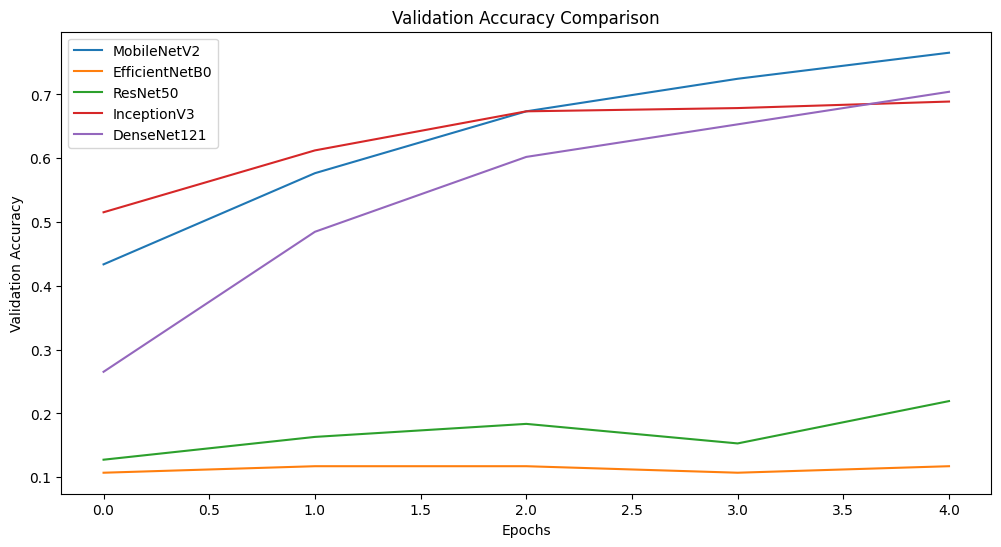

In [ ]:
# Ploting the results
plt.figure(figsize=(12, 6))

for model_name, val_acc in history_dict.items():
    plt.plot(val_acc, label=model_name)

plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

# Conclusion

Based on the results shown in the chart above, the best-performing base model is **MobileNetV2**, followed by **DenseNet121**.

An important observation is the poor performance of **EfficientNetB0** and **ResNet50**, which failed to learn effectively. This may be due to several factors:
- The classifier layer added after these models might be too simple for their complex feature extraction capabilities.
- The learning rate might have been too high for these deeper models.

Since the objective of this project is to develop an MVP model to validate the idea, I will focus on optimizing **MobileNetV2** without further testing.

However, for a production-level model, I would continue experimenting with different hyperparameters, fine-tuning strategies, and classifier architectures before making a final decision.

---

# Finding The Best Classifier for MobileNetV2

In this section, I first freeze the base model (MobileNetV2) and experiment with different classifier architectures to identify the best-performing configuration. This includes testing various combinations of dense layers, units, and learning rates.

In [11]:
def hypermodel_builder(hp):
  """
  Builds a Keras model with hyperparameters for optimization, including BatchNormalization.

  Args:
    hp (kt.HyperParameters): Hyperparameter search space.

  Returns:
    model (tf.keras.Model): Compiled Keras model.
  """
  # Load base-model
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
  base_model.trainable = False  # Initially freeze base model

  # Classifier Layers (Dynamically Configured)
  x = base_model.output
  x = GlobalAveragePooling2D()(x)

  # Dynamic Dense Layers (1 to 3 Layers)
  for i in range(hp.Int('num_layers', 1, 3)):
    units = hp.Int(f'units_{i}', min_value=64, max_value=512, step=64)
    x = Dense(units, activation='relu')(x)

    # Optional BatchNormalization
    if hp.Boolean('batch_norm'):
      x = BatchNormalization()(x)

      x = Dropout(hp.Float('dropout_rate', 0.2, 0.6, step=0.1))(x)

  # Output Layer (10 classes)
  x = Dense(10, activation='softmax')(x)

  model = Model(inputs=base_model.input, outputs=x)

  # Compile Model
  model.compile(
      optimizer=Adam(hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  return model

In [12]:
# Define Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,  # Stop if no improvement in 5 epochs
    restore_best_weights=True,  # Load the best weights
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    "best_model.h5",  # Save the best model as this file
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce LR by half
    patience=3,  # Wait 3 epochs before reducing
    min_lr=1e-7,  # Minimum learning rate
    verbose=1
)

In [13]:
tuner = RandomSearch(
    hypermodel_builder,
    objective='val_accuracy',
    max_trials=25,
    executions_per_trial=1,
    directory='tuning_results',
    project_name='delisio_mvp'
)

tuner.search(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)

Trial 25 Complete [00h 29m 45s]
val_accuracy: 0.8673469424247742

Best val_accuracy So Far: 0.9132652878761292
Total elapsed time: 09h 31m 39s


In [16]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(1)[0]

print(f"Best Number of Layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"Layer {i+1} Units: {best_hps.get(f'units_{i}')}")
print(f"Best Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")
print(f"Include BatchNormalization: {best_hps.get('batch_norm')}")


Best Number of Layers: 1
Layer 1 Units: 256
Best Dropout Rate: 0.5
Best Learning Rate: 0.00036910691744710154
Include BatchNormalization: False


# Conclusion

After 25 trials of hyperparameter optimization using KerasTuner, the best-performing classifier for the MobileNetV2 base model was identified with the following configuration:

- Number of Dense Layers: 1
- Units in Dense Layer: 256
- Dropout Rate: 0.5
- Learning Rate: 0.000369
- Batch Normalization: Not included

---
# Training the model with freezed base model

Next, I train the model with hyperparameters found in the previous experiment for 100 epochs so that it has more time to learn. All 150 layers of the base model are freezed at this step and on further steps, some of the layers will be unfreezed to fine-tuning.  

In [14]:
# Load Base Model (MobileNetV2)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Build Best Model from KerasTuner
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(
    optimizer=Adam(learning_rate=0.000369),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    "food_classifier.h5",  # Save best model
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce LR by half if no improvement
    patience=5,  # Wait 5 epochs before reducing
    min_lr=1e-7,  # Minimum learning rate
    verbose=1
)

# Train for 100 epochs with best hyperparameters
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3195 - loss: 2.0932
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to food_classifier.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.3222 - loss: 2.0847 - val_accuracy: 0.7500 - val_loss: 0.8973 - learning_rate: 3.6900e-04
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6956 - loss: 0.9297
Epoch 2: val_accuracy improved from 0.75000 to 0.83163, saving model to food_classifier.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.6958 - loss: 0.9292 - val_accuracy: 0.8316 - val_loss: 0.6321 - learning_rate: 3.6900e-04
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7764 - loss: 0.7276
Epoch 3: val_accuracy improved from 0.83163 to 0.85714, saving model to food_classifier.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7764 - loss: 0.7268 - val_accuracy: 0.8571 - val_loss: 0.5428 - learning_rate: 3.6900e-04
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8280 - loss: 0.5578
Epoch 4: val_accuracy did not improve from 0.85714
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8280 - loss: 0.5578 - val_accuracy: 0.8469 - val_loss: 0.5073 - learning_rate: 3.6900e-04
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8326 - loss: 0.5419
Epoch 5: val_accuracy improved from 0.85714 to 0.86735, saving model to food_classifier.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8327 - loss: 0.5414 - val_accuracy: 0.8673 - val_loss: 0.4556 - learning_rate: 3.6900e-04
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8255 - loss: 0.5400
Epoch 6: val_accuracy did not improve from 0.86735
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8258 - loss: 0.5390 - val_accuracy: 0.8571 - val_loss: 0.4784 - learning_rate: 3.6900e-04
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8675 - loss: 0.4243
Epoch 7: val_accuracy did not improve from 0.86735
51/51 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8674 - loss: 0.4244 - val_accuracy: 0.8469 - val_loss: 0.4308 - learning_rate: 3.6900e-04
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8709 - loss: 0.4032
Epoch 8: val_accuracy did not improve from 0.86735
51/51 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8710 - loss: 0.4030 - val_accuracy: 0.8673 - val_loss: 0.4307 - learning_rate: 3.6900e-04
Epoch 9/100
51/51 ━━━━━

51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8884 - loss: 0.3565 - val_accuracy: 0.8929 - val_loss: 0.4119 - learning_rate: 3.6900e-04
Epoch 11/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8920 - loss: 0.3224
Epoch 11: val_accuracy did not improve from 0.89286
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8920 - loss: 0.3226 - val_accuracy: 0.8724 - val_loss: 0.3919 - learning_rate: 3.6900e-04
Epoch 12/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9060 - loss: 0.3095
Epoch 12: val_accuracy did not improve from 0.89286
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9059 - loss: 0.3098 - val_accuracy: 0.8878 - val_loss: 0.3999 - learning_rate: 3.6900e-04
Epoch 13/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8970 - loss: 0.2937
Epoch 13: val_accuracy did not improve from 0.89286
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8972 - loss: 0.2939 - val_accuracy: 0.8622 - val_loss: 0.4254 - learning_rate: 3.6900e-04
Epoch 14/100
51/5

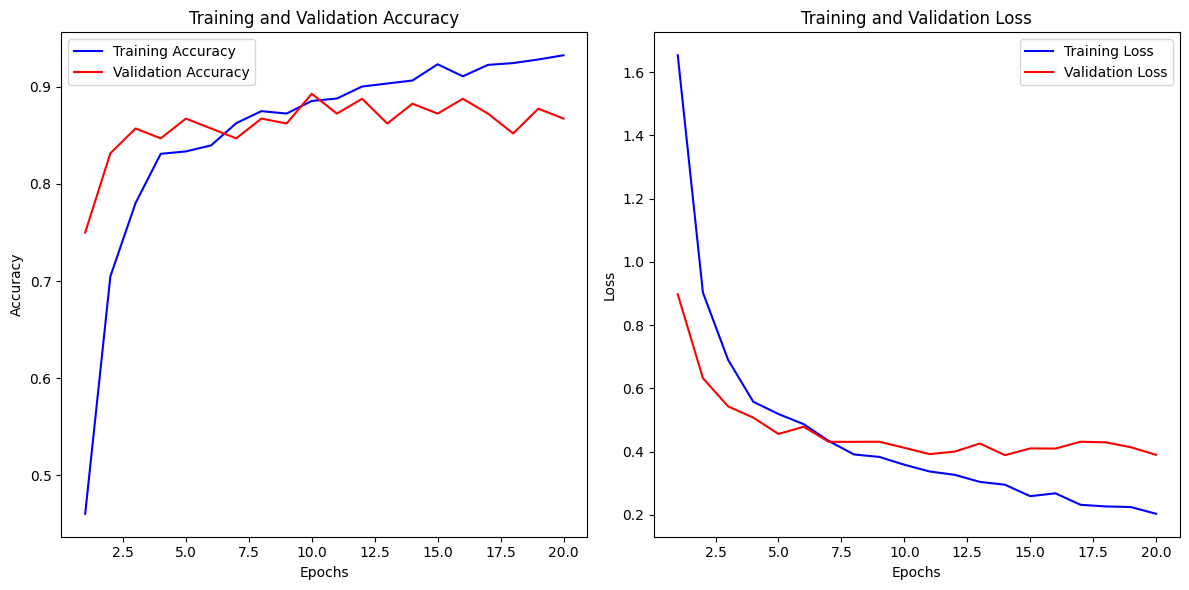

In [15]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy/loss from the training history.

    Args:
        history (History): The Keras training history object.
    """
    # Extract values from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plotting Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Use the function
plot_training_history(history)


Found 196 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 979ms/step
Classification Report:

               precision    recall  f1-score   support

       burger       0.91      1.00      0.95        21
fried_chicken       0.95      0.95      0.95        20
        kebab       0.76      0.84      0.80        19
       paella       0.92      0.96      0.94        23
        pasta       0.87      0.81      0.84        16
        pizza       0.89      0.80      0.84        20
        ramen       0.88      0.95      0.91        22
        steak       0.94      0.94      0.94        17
        sushi       0.91      0.95      0.93        21
        tacos       0.92      0.65      0.76        17

     accuracy                           0.89       196
    macro avg       0.89      0.89      0.89       196
 weighted avg       0.89      0.89      0.89       196



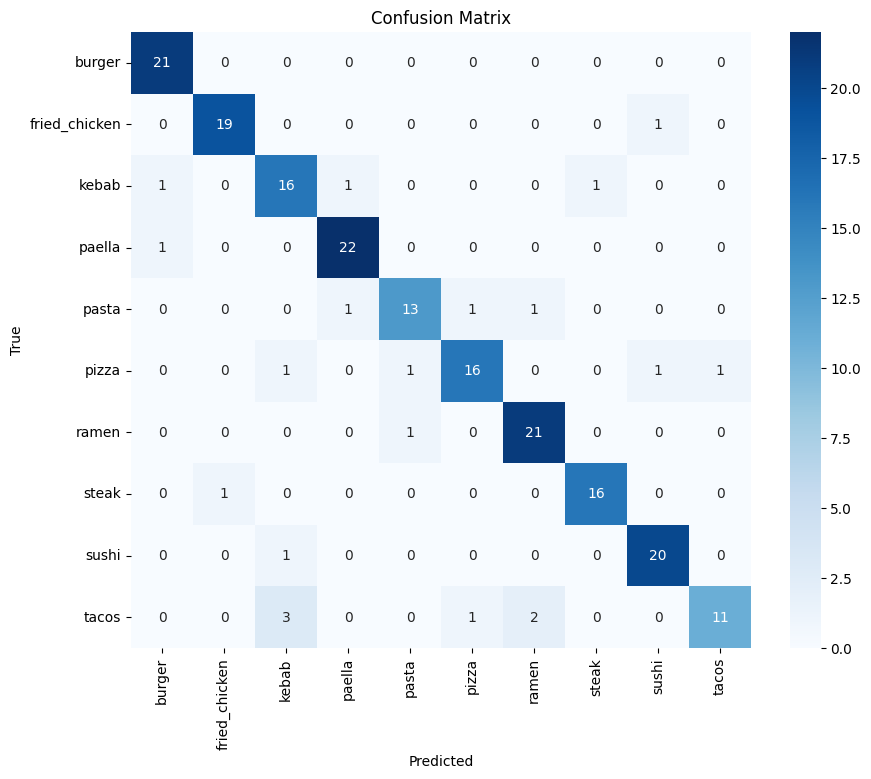

In [28]:
# Create a temporary validation generator (shuffle=False)
val_gen_temp = val_test_datagen.flow_from_directory(
    os.path.join(data_dir, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  # Important: No shuffle for consistent order
)

# Predicting on the entire validation set
val_gen_temp.reset()  # Ensure the generator starts from the beginning
val_pred = model.predict(val_gen_temp, steps=val_gen_temp.samples // val_gen_temp.batch_size + 1, verbose=1)
y_true = val_gen_temp.classes
y_pred = np.argmax(val_pred, axis=1)

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=val_gen_temp.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=val_gen_temp.class_indices.keys(),
            yticklabels=val_gen_temp.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Conclusion

As shown in the training and validation loss figure, the model was able to learn smoothly with out overfitting and achieved 89% accuracy. Also the confusion matrix shows a balanced performace across 10 classes.

---

# Fine-Tuning

MobileNetV2 has approximately 150 layers, to find the optimal number of layers to unfreez, I retrain the model from previous step for 10 times, I start with unfreezing last 10 layer and increase it by 10 each time.

In [20]:
# Load the Best Frozen Model (this is your best base model)
model.load_weights("food_classifier.h5")

# Range of unfreezing (10, 20, ..., 100)
unfreeze_range = list(range(10, 101, 10))
fine_tune_results = []

for layers_to_unfreeze in unfreeze_range:
    print(f"\nFine-tuning with Last {layers_to_unfreeze} Layers Unfrozen...")

    # Re-load the best frozen model before each test
    model.load_weights("food_classifier.h5")
    base_model.trainable = True

    # Unfreeze the specified number of layers
    for layer in base_model.layers[:-layers_to_unfreeze]:
        layer.trainable = False

    # Compile with a lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=1e-6),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fine-tune the model
    fine_tune_history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=15,  # Shorter training for fast testing
        callbacks=[
            EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
            ModelCheckpoint(f"fine_tuned_{layers_to_unfreeze}_layers.h5", monitor='val_accuracy', save_best_only=True)
        ],
        verbose=1
    )

    # Record best validation accuracy
    best_val_acc = max(fine_tune_history.history['val_accuracy'])
    fine_tune_results.append((layers_to_unfreeze, best_val_acc))
    print(f"Validation Accuracy with {layers_to_unfreeze} Layers Unfrozen: {best_val_acc:.4f}")


Fine-tuning with Last 10 Layers Unfrozen...
Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7742 - loss: 0.7007

51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7742 - loss: 0.7003 - val_accuracy: 0.8929 - val_loss: 0.4104
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7627 - loss: 0.7011 - val_accuracy: 0.8929 - val_loss: 0.4093
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7929 - loss: 0.6043 - val_accuracy: 0.8929 - val_loss: 0.4089
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7851 - loss: 0.6379 - val_accuracy: 0.8929 - val_loss: 0.4087
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7891 - loss: 0.6480 - val_accuracy: 0.8929 - val_loss: 0.4081
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8006 - loss: 0.6131 - val_accuracy: 0.8929 - val_loss: 0.4086
Validation Accuracy with 10 Layers Unfrozen: 0.8929

Fine-tuning with Last 20 Layers Unfrozen...
Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7796 - loss: 0.6831

51/51 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7794 - loss: 0.6835 - val_accuracy: 0.8929 - val_loss: 0.4101
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7602 - loss: 0.7135 - val_accuracy: 0.8929 - val_loss: 0.4089
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7761 - loss: 0.7048 - val_accuracy: 0.8929 - val_loss: 0.4080
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7723 - loss: 0.6852 - val_accuracy: 0.8929 - val_loss: 0.4079
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7789 - loss: 0.6479 - val_accuracy: 0.8929 - val_loss: 0.4078
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8102 - loss: 0.6115 - val_accuracy: 0.8929 - val_loss: 0.4077
Validation Accuracy with 20 Layers Unfrozen: 0.8929

Fine-tuning with Last 30 Layers Unfrozen...
Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7906 - loss: 0.6818

51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7904 - loss: 0.6818 - val_accuracy: 0.8929 - val_loss: 0.4103
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7815 - loss: 0.7021 - val_accuracy: 0.8929 - val_loss: 0.4090
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7715 - loss: 0.6942 - val_accuracy: 0.8929 - val_loss: 0.4085
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7997 - loss: 0.6186 - val_accuracy: 0.8929 - val_loss: 0.4084
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7760 - loss: 0.6579 - val_accuracy: 0.8929 - val_loss: 0.4084
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8104 - loss: 0.5892 - val_accuracy: 0.8878 - val_loss: 0.4086
Validation Accuracy with 30 Layers Unfrozen: 0.8929

Fine-tuning with Last 40 Layers Unfrozen...
Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7444 - loss: 0.7513

51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7446 - loss: 0.7508 - val_accuracy: 0.8929 - val_loss: 0.4100
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7832 - loss: 0.6647 - val_accuracy: 0.8929 - val_loss: 0.4090
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8071 - loss: 0.5783 - val_accuracy: 0.8929 - val_loss: 0.4086
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7975 - loss: 0.6369 - val_accuracy: 0.8929 - val_loss: 0.4080
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7831 - loss: 0.6488 - val_accuracy: 0.8929 - val_loss: 0.4077
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8356 - loss: 0.5569 - val_accuracy: 0.8929 - val_loss: 0.4077
Validation Accuracy with 40 Layers Unfrozen: 0.8929

Fine-tuning with Last 50 Layers Unfrozen...
Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7664 - loss: 0.7045

51/51 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7663 - loss: 0.7048 - val_accuracy: 0.8929 - val_loss: 0.4102
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7811 - loss: 0.6753 - val_accuracy: 0.8929 - val_loss: 0.4089
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7950 - loss: 0.6583 - val_accuracy: 0.8929 - val_loss: 0.4083
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7818 - loss: 0.6661 - val_accuracy: 0.8929 - val_loss: 0.4080
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8088 - loss: 0.6375 - val_accuracy: 0.8929 - val_loss: 0.4076
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8109 - loss: 0.6052 - val_accuracy: 0.8929 - val_loss: 0.4077
Validation Accuracy with 50 Layers Unfrozen: 0.8929

Fine-tuning with Last 60 Layers Unfrozen...
Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7643 - loss: 0.6922

51/51 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7642 - loss: 0.6924 - val_accuracy: 0.8929 - val_loss: 0.4103
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7613 - loss: 0.6918 - val_accuracy: 0.8929 - val_loss: 0.4090
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8021 - loss: 0.6278 - val_accuracy: 0.8929 - val_loss: 0.4087
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7804 - loss: 0.6654 - val_accuracy: 0.8929 - val_loss: 0.4080
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8009 - loss: 0.6424 - val_accuracy: 0.8929 - val_loss: 0.4074
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7934 - loss: 0.6348 - val_accuracy: 0.8929 - val_loss: 0.4076
Validation Accuracy with 60 Layers Unfrozen: 0.8929

Fine-tuning with Last 70 Layers Unfrozen...
Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7612 - loss: 0.7396

51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7613 - loss: 0.7392 - val_accuracy: 0.8929 - val_loss: 0.4098
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7991 - loss: 0.6201 - val_accuracy: 0.8929 - val_loss: 0.4083
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7565 - loss: 0.7003 - val_accuracy: 0.8929 - val_loss: 0.4077
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7872 - loss: 0.6723 - val_accuracy: 0.8929 - val_loss: 0.4076
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7899 - loss: 0.6598

51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7900 - loss: 0.6593 - val_accuracy: 0.8980 - val_loss: 0.4076
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7852 - loss: 0.6339 - val_accuracy: 0.8929 - val_loss: 0.4075
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7809 - loss: 0.6300 - val_accuracy: 0.8878 - val_loss: 0.4079
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7724 - loss: 0.6721 - val_accuracy: 0.8878 - val_loss: 0.4086
Epoch 9/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8088 - loss: 0.6215 - val_accuracy: 0.8878 - val_loss: 0.4102
Epoch 10/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7987 - loss: 0.6440 - val_accuracy: 0.8827 - val_loss: 0.4113
Validation Accuracy with 70 Layers Unfrozen: 0.8980

Fine-tuning with Last 80 Layers Unfrozen...
Epoch 1/15
49/51 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7809 - loss: 0.6906

51/51 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7808 - loss: 0.6904 - val_accuracy: 0.8929 - val_loss: 0.4101
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7533 - loss: 0.7283 - val_accuracy: 0.8929 - val_loss: 0.4088
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7907 - loss: 0.6285 - val_accuracy: 0.8929 - val_loss: 0.4082
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7980 - loss: 0.6367 - val_accuracy: 0.8929 - val_loss: 0.4080
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8043 - loss: 0.6032 - val_accuracy: 0.8929 - val_loss: 0.4080
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7937 - loss: 0.6188 - val_accuracy: 0.8929 - val_loss: 0.4076
Validation Accuracy with 80 Layers Unfrozen: 0.8929

Fine-tuning with Last 90 Layers Unfrozen...
Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7647 - loss: 0.6944

51/51 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7647 - loss: 0.6947 - val_accuracy: 0.8929 - val_loss: 0.4101
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7716 - loss: 0.7271 - val_accuracy: 0.8929 - val_loss: 0.4087
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7958 - loss: 0.6521 - val_accuracy: 0.8929 - val_loss: 0.4087
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7979 - loss: 0.6213 - val_accuracy: 0.8929 - val_loss: 0.4087
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8044 - loss: 0.6096 - val_accuracy: 0.8929 - val_loss: 0.4086
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8045 - loss: 0.6045 - val_accuracy: 0.8878 - val_loss: 0.4090
Validation Accuracy with 90 Layers Unfrozen: 0.8929

Fine-tuning with Last 100 Layers Unfrozen...
Epoch 1/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7694 - loss: 0.7458

51/51 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7696 - loss: 0.7451 - val_accuracy: 0.8929 - val_loss: 0.4101
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7747 - loss: 0.7091 - val_accuracy: 0.8929 - val_loss: 0.4092
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7603 - loss: 0.7004 - val_accuracy: 0.8929 - val_loss: 0.4086
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7991 - loss: 0.6368 - val_accuracy: 0.8929 - val_loss: 0.4082
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7848 - loss: 0.6337 - val_accuracy: 0.8929 - val_loss: 0.4080
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7894 - loss: 0.6344 - val_accuracy: 0.8929 - val_loss: 0.4081
Validation Accuracy with 100 Layers Unfrozen: 0.8929


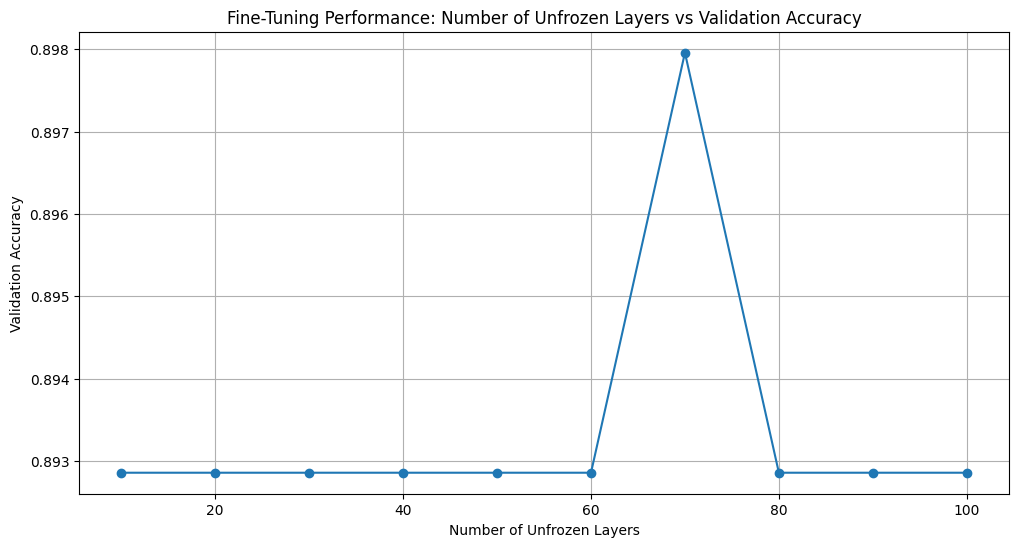

In [21]:
# Plotting the results
unfreeze_layers, val_accuracies = zip(*fine_tune_results)
plt.figure(figsize=(12, 6))
plt.plot(unfreeze_layers, val_accuracies, marker='o')
plt.title("Fine-Tuning Performance: Number of Unfrozen Layers vs Validation Accuracy")
plt.xlabel("Number of Unfrozen Layers")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()

In [15]:
# Evaluating final model
best_fine_tuned_model = load_model("/content/fine_tuned_70_layers.h5")

test_loss, test_acc = best_fine_tuned_model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy of Fine-Tuned Model: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9463 - loss: 0.2263
Test Accuracy of Fine-Tuned Model: 0.9249


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 752ms/step


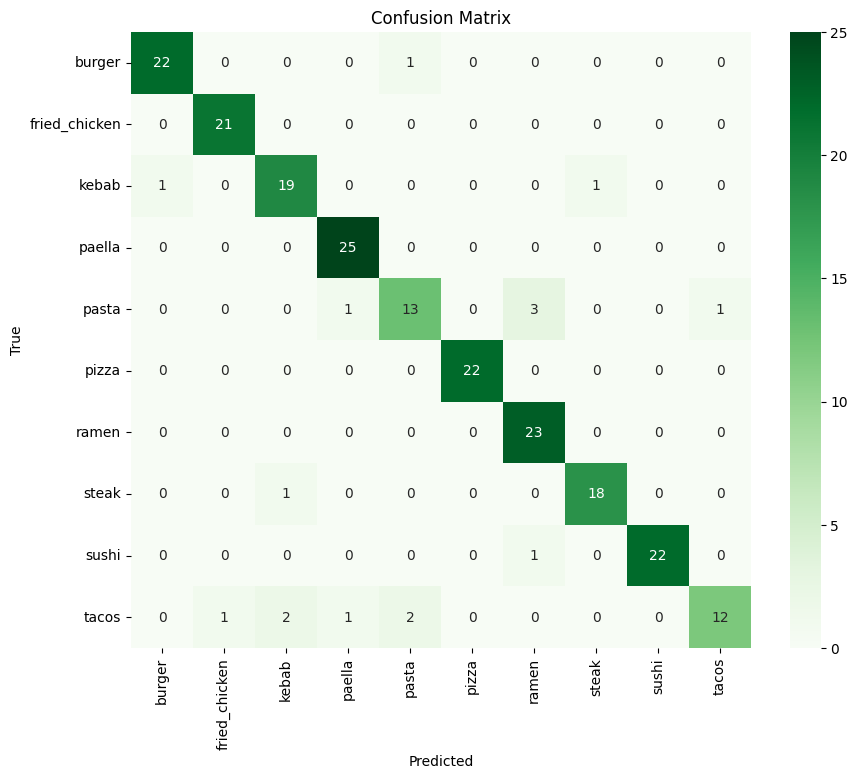

Classification Report:

               precision    recall  f1-score   support

       burger     0.9565    0.9565    0.9565        23
fried_chicken     0.9545    1.0000    0.9767        21
        kebab     0.8636    0.9048    0.8837        21
       paella     0.9259    1.0000    0.9615        25
        pasta     0.8125    0.7222    0.7647        18
        pizza     1.0000    1.0000    1.0000        22
        ramen     0.8519    1.0000    0.9200        23
        steak     0.9474    0.9474    0.9474        19
        sushi     1.0000    0.9565    0.9778        23
        tacos     0.9231    0.6667    0.7742        18

     accuracy                         0.9249       213
    macro avg     0.9235    0.9154    0.9163       213
 weighted avg     0.9256    0.9249    0.9223       213



In [18]:
# Predict on the test set
test_gen.reset()
test_pred = best_fine_tuned_model.predict(test_gen, steps=test_gen.samples // test_gen.batch_size + 1, verbose=1)
y_true = test_gen.classes
y_pred = np.argmax(test_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report (Precision, Recall, F1-Score)
class_report = classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys(), digits=4)
print("Classification Report:\n")
print(class_report)


# Conclusion

In this notebook, I conducted a detailed series of experiments to develop a reliable food classification model using transfer learning. The process began with the creation of a high quality custom dataset through web scraping, which was then manually reviewed for quality, resized to 224x224 pixels, and split into training, validation, and test sets in an 80/10/10 ratio.

I experimented with five pre-trained models, and the results showed that **MobileNetV2** was the most suitable for this task. To further optimize the model, I utilized **Keras Tuner** to identify the best set of hyperparameters. Following this, I fine-tuned the model by selectively unfreezing layers, ultimately achieving the best performance with the last 70 layers unfrozen. The final model achieved an accuracy of **92.56%**.

The dataset and the final model are publicly available on this [GitHub](https://github.com/PeymanKh/delisio_mvp) repo.
